# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the third stage: **Capacity and generation analysis**

-Goal: conduct analysis of power generation estimation, capacity, and capacity factor under via assumptions of maximum and minimum capacity profiles.

-Steps: Calculate the installed capacity and estimate the power generation for comparison:
1. Import data (data from stage 2, and data for three methods)
2. Setup assumptions based on data from stage 2 (whole country and regional division)<br>
3. Capacity factor from four different regions in Vietnam<br>
-Regional division & whole country<br>
4. Calculate the potentials capacity & annual generation via assumptions of maximum and minimum performance (HC/LC) of wind turbines and pv panels<br>
-Regional division & whole country<br>
**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

In [1]:
# import necessary library
# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline
import matplotlib.pyplot as plt # Convention for import of the pyplot interface
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
import os # operating system interfaces 
import datetime # time data sorting
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import seaborn as sns # Use seaborn style defaults and set the default figure size
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package

In [2]:
# Method 2 function: define function of time sorting (variables: input_df)
def time_sort(input_df):
    # reset time column into date time and select it as new index
    input_df.set_index('local_time')
    # add year, month and day name
    input_df['year'] = 2019
    input_df['month'] = pd.DatetimeIndex(input_df['local_time']).month
    input_df['day'] = pd.DatetimeIndex(input_df['local_time']).day
    input_df['hour'] = pd.DatetimeIndex(input_df['local_time']).hour
    # add last six hours back to beginning and replace the time stamp
    input_df['local_time'] = pd.to_datetime(input_df[['year', 'month', 'day', 'hour']])
    # sort by time
    input_df.sort_values(by=['local_time'], inplace = True)
    return input_df

In [3]:
# calculation of total average capacity factor: define function of aonnual conversion (variables: output_df, input_df)
def cal_cf(output_df, input_df):
    # Using for loop to take mean value of all longtitudes and latitudes in each hour of the year
    for i in range(1, 13): # months from January to December
        for j in range(1,32): # day from 1 to 31 
            for k in range (0,24): # hours from 0 to 23
                select_df = input_df.loc[(input_df['month'] == i) & (input_df['day'] == j) & (input_df['hour'] == k)] # locate the hours 
                avg_time = select_df['local_time'].mean(axis = 0, skipna = True) # take mean value of the hour
                avg_gen = select_df['capacity_factor'].mean(axis = 0, skipna = True) # take mean value of the hour
                
                output_df = output_df.append({'time': avg_time,'year': 2019,'month': i,'day': j,'hour': k,'capacity_factor': avg_gen}, ignore_index=True) # add the values into new Dataframe
    # correct the value in time column from string into integer
    output_df['year'] = output_df['year'].astype(np.int64)
    output_df['month'] = output_df['month'].astype(np.int64)
    output_df['day'] = output_df['day'].astype(np.int64)
    output_df['hour'] = output_df['hour'].astype(np.int64)

    return output_df

## 1. Import data (data from stage 2, and data for method 2)

### a. Import the **land area** from the **result of stage 2**

In [4]:
land_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv') # Import final available land (from stgae 2)
sc3_wind_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_wind.csv') # Import result data of wind resources from stge 2
sc3_solar_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_solar.csv') # Import result data of solar resources from stge 2

### b. Import data for method 2

In [5]:
# Wind Speed and Solar Radiation data for Method 3
# Select the csv files from time-series folder
path = 'Vietnam/00_data_time_series/RenewablesNinja/'
path_file = os.listdir(path)    
files = list(filter(lambda f: f.endswith('.csv'), path_file))

# corresponding cities and data
city_df = pd.read_excel('Vietnam/00_data_time_series/RenewablesNinja/Cities_vn.xlsx',sheet_name='cities_long_la')
city = city_df['city']
city_lat = city_df['Lat']
city_long = city_df['Long']
city_types = city_df['Types']

## 2. Setup assumptions based on data from stage 2 (whole country and regional division)

### a. Calculate the total land area

In [6]:
name = 'Vietnam'
land_sum = land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', land_sum,'km^2')

Total area of scenario 3 in Vietnam : 1609.2473186850455 km^2


### b. Divide the land area into different regions and Calculate the land area of different regions
The regions area defined based on https://en.wikipedia.org/wiki/List_of_regions_of_Vietnam

In [7]:
# separate into regions: Northeast, Northwest, Red River Delta, North Central Coast, South Central Coast, Central Highlands, Southeast, Mekong River Delta 
nw_arr = ['Dien Bien','Hoa Binh', 'Lai Chau', 'Lao Cai', 'Son La', 'Yen Bai'] 
ne_arr = ['Bac Giang','Bac Kann', 'Cao Bangu', 'Ha Giang', 'Lang Son', 'Phu Tho', 'Quang Ninh', 'Thai Nguyen', 'Tuyen Quang'] 
rrd_arr = ['Bac Ninh', 'Ha Nam', 'Ha Noi', 'Hai Duong', 'Hai Phong', 'Hung Yen', 'Nam Dinh', 'Ninh Binh', 'Thai Binh', 'Vinh Phuc'] 
ncc_arr = ['Ha Tinh', 'Nghe An', 'Quang Binh', 'Quang Tri', 'Thanh Hoa', 'Thua Thien Hue']
scc_arr = ['Binh Dinh', 'Binh Thuan', 'Da Nang', 'Khanh Hoa', 'Ninh Thuan', 'Phu Yen', 'Quang Nam', 'Quang Ngai']
ch_arr = ['Dak Lak', 'Dak Nong', 'Gia Lai', 'Kon Tum', 'Lam Dong']
se_arr = ['Ba Ria Vung Tau', 'Binh Duong', 'Binh Phuoc', 'Dong Nai', 'Saigon', 'Tay Ninh'] 
mrd_arr = ['An Giang', 'Ben Tre', 'Bac Lieu', 'Ca Mau', 'Can Tho City', 'Dong Thap', 'Hau Giang',
             'Kien Giang', 'Long An', 'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long']

region_name = ['Northwest', 'Northeast', 'Red River Delta', 'North Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']
region_arr = [nw_arr, ne_arr, rrd_arr, ncc_arr, scc_arr, ch_arr, se_arr, mrd_arr]
region_dict = {} # empty dictionary
region_area_dict = {} # empty dictionary
for i in range(len(region_arr)):
    region_dict[region_name[i]] = land_gdf[land_gdf['ad_lv_1'].str.contains('|'.join(region_arr[i]))] # Northwest
    region_area_dict[region_name[i]] = region_dict[region_name[i]]['area_km2'].sum(axis = 0, skipna = True)

## 3. Capacity factor from four different regions in Vietnam
-Regional division & whole country<br>

**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. Regional division

In [8]:
# Import first region to initiate the dataframe
# solar capactiy factor
pv_fileOne_df = pd.read_csv( path + files[0])
pv_fileOne_df['city']=city[0]
pv_fileOne_df['latitude']=city_lat[0]
pv_fileOne_df['longtitude']=city_long[0]
pv_fileOne_df['type']=city_types[0]
pv_fileOne_df.rename(columns={'electricity': 'capacity_factor'}, inplace = True)
pv_fileOne_df = pv_fileOne_df[['city', 'latitude', 'longtitude', 'type', 'local_time', 'capacity_factor']]
# wind capactiy factor
wt_fileOne_df = pd.read_csv(path + files[10])
wt_fileOne_df['city']=city[10]
wt_fileOne_df['latitude']=city_lat[10]
wt_fileOne_df['longtitude']=city_long[10]
wt_fileOne_df['type']=city_types[10]
wt_fileOne_df.rename(columns={'electricity': 'capacity_factor'}, inplace = True)
wt_fileOne_df = wt_fileOne_df[['city', 'latitude', 'longtitude', 'type', 'local_time', 'capacity_factor']]

# put rest of regions into the dataframe
# solar capactiy factor
for i in range(1, 10):
    pv_files_df = pd.read_csv(path + files[i])
    pv_files_df['city']=city[i]
    pv_files_df['latitude']=city_lat[i]
    pv_files_df['longtitude']=city_long[i]
    pv_files_df['type']=city_types[i]
    pv_files_df.rename(columns={'electricity': 'capacity_factor'}, inplace = True)
    pv_files_df = pv_files_df[['city', 'latitude', 'longtitude', 'type', 'local_time', 'capacity_factor']]
    pv_fileOne_df = pv_fileOne_df.append(pv_files_df)

# wind capactiy factor
for i in range(11, len(files)):
    wt_files_df = pd.read_csv(path + files[i])
    wt_files_df['city']=city[i]
    wt_files_df['latitude']=city_lat[i]
    wt_files_df['longtitude']=city_long[i]
    wt_files_df['type']=city_types[i]
    wt_files_df.rename(columns={'electricity': 'capacity_factor'}, inplace = True)
    wt_files_df = wt_files_df[['city', 'latitude', 'longtitude', 'type', 'local_time', 'capacity_factor']]
    wt_fileOne_df = wt_fileOne_df.append(wt_files_df)

pv_fileOne_df.to_csv('Vietnam/03_output_stage3/03_vn_annual_hourly_pv_cf_regional.csv', index = True)
wt_fileOne_df.to_csv('Vietnam/03_output_stage3/03_vn_annual_hourly_wind_cf_regional.csv', index = True)
pv_fileOne_df.head()

,city,latitude,longtitude,type,local_time,capacity_factor
0,BuonMaThuot,12.6797,108.0447,PHOT,01/01/2019 07:00,0.082
1,BuonMaThuot,12.6797,108.0447,PHOT,01/01/2019 08:00,0.198
2,BuonMaThuot,12.6797,108.0447,PHOT,01/01/2019 09:00,0.297
3,BuonMaThuot,12.6797,108.0447,PHOT,01/01/2019 10:00,0.341
4,BuonMaThuot,12.6797,108.0447,PHOT,01/01/2019 11:00,0.338


### b. Whole Country

In [9]:
%%time
# Solar capactiy factor
pv_sort_df = pv_fileOne_df.copy()
pv_sort_df = time_sort(pv_sort_df)
pv_cf_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'capacity_factor'])
pv_cf_df = cal_cf(pv_cf_df, pv_sort_df)
pv_cf_df = pv_cf_df.dropna()

# wind capactiy factor
wt_sort_df = wt_fileOne_df.copy()
wt_sort_df = time_sort(wt_sort_df)
wt_cf_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'capacity_factor'])
wt_cf_df = cal_cf(wt_cf_df, wt_sort_df)
wt_cf_df = wt_cf_df.dropna()

# Save csv file 
pv_cf_df.to_csv('Vietnam/03_output_stage3/03_vn_annual_hourly_pv_cf_national.csv', index = True)
wt_cf_df.to_csv('Vietnam/03_output_stage3/03_vn_annual_hourly_wind_cf_national.csv', index = True)

pv_cf_df.head()

Wall time: 2min 17s


,time,year,month,day,hour,capacity_factor
0,2019-01-01 00:00:00,2019,1,1,0,0.0
1,2019-01-01 01:00:00,2019,1,1,1,0.0
2,2019-01-01 02:00:00,2019,1,1,2,0.0
3,2019-01-01 03:00:00,2019,1,1,3,0.0
4,2019-01-01 04:00:00,2019,1,1,4,0.0


## 4. Calculate the potentials capacity & annual generation via assumptions of maximum and minimum performance (HC/LC) of wind turbines and pv panels
-Regional division & whole country<br>

**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. HC/LC profile assumptions

In [10]:
# shares of utility solar pv and onshore wind farm
pv_sh = 0.5
wt_sh = 0.5

# solar HC/LC profile
pv_hc_c = 650 # capactiy of one PV panel according to High Capacity (HC) Profile (650 Wp) / Power Density (300 W/km2)
pv_hc_pd = 300
pv_lc_c = 250 # capactiy of one PV panel according to Low Capacity (LC) Profile (250 Wp)/ Power Density (50 W/km2)
pv_lc_pd = 50
pv_ef = 0.2 # efficiency factor of the PV modules: 20 (%)

# wind HC/LC profile
wt_hc_c = 7.5 # capactiy of one wind turbine according to High Capacity (HC) Profile (7.5 MW)
wt_lc_c = 1 # capactiy of one wind turbine according to Low Capacity (LC) Profile (1 MW)
dia = 0.1 # rotor diameter (km)
wt_d = 5*dia*5*dia # distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)

### b. Calculation of capacity and generation of HC/LC Profiles

In [12]:
# solar HC/LC profile
# potential capacity of HC/LC profile (GW) = (50% of land area * power density of one PV panel) / 1000
pv_pc_lc = land_sum*pv_sh*pv_lc_pd/1000
pv_pc_hc = land_sum*pv_sh*pv_hc_pd/1000

# average capacity factor of the whole country
pv_cf = pv_cf_df['capacity_factor'].mean(axis = 0, skipna = True)

# estimated annual generation of HC/LC profile (TWh) = (potential capacity * capactiy factor * 8760 hours) / 1000
pv_ag_hourly_df = pv_cf_df.copy()
pv_ag_hourly_df['LC_generation_Twh'] = pv_pc_lc*pv_ag_hourly_df['capacity_factor']/1000
pv_ag_hourly_df['HC_generation_Twh'] = pv_pc_hc*pv_ag_hourly_df['capacity_factor']/1000
pv_ag_lc = pv_ag_hourly_df['LC_generation_Twh'].sum()
pv_ag_hc = pv_ag_hourly_df['HC_generation_Twh'].sum()


# wind HC/LC profile
# potential capacity of HC/LC profile (GW) = (50% of land area * capacity of one wind turbine) / (distance between wind turbines * 1000)
wt_pc_lc = land_sum*wt_sh*wt_lc_c/wt_d/1000
wt_pc_hc = land_sum*wt_sh*wt_hc_c/wt_d/1000

# average capacity factor of the whole country
wt_cf = wt_cf_df['capacity_factor'].mean(axis = 0, skipna = True)

# estimated annual generation of HC/LC profile (TWh) = (potential capacity * 8760 hours) / 1000
wt_ag_hourly_df = wt_cf_df.copy()
wt_ag_hourly_df['LC_generation_Twh'] = wt_pc_lc*wt_ag_hourly_df['capacity_factor']/1000
wt_ag_hourly_df['HC_generation_Twh'] = wt_pc_hc*wt_ag_hourly_df['capacity_factor']/1000
wt_ag_lc = wt_ag_hourly_df['LC_generation_Twh'].sum()
wt_ag_hc = wt_ag_hourly_df['HC_generation_Twh'].sum()

# final_df
profile_df = pd.DataFrame(columns=['Type', 'Profile', 'Potential_Installed_Capacity_GW', 'Capacity_Factor', 'Estimated_Annual_Generation_TWh'])
profile_df = profile_df.append({'Type': 'Utility PV',  'Profile': 'LC', 'Potential_Installed_Capacity_GW': pv_pc_lc,'Capacity_Factor': pv_cf,'Estimated_Annual_Generation_TWh': pv_ag_lc}, ignore_index=True)
profile_df = profile_df.append({'Type': 'Utility PV',  'Profile': 'HC', 'Potential_Installed_Capacity_GW': pv_pc_hc,'Capacity_Factor': pv_cf,'Estimated_Annual_Generation_TWh': pv_ag_hc}, ignore_index=True)
profile_df = profile_df.append({'Type': 'OnShore Wind Farm',  'Profile': 'LC', 'Potential_Installed_Capacity_GW': wt_pc_lc,'Capacity_Factor': wt_cf,'Estimated_Annual_Generation_TWh': wt_ag_lc}, ignore_index=True)
profile_df = profile_df.append({'Type': 'OnShore Wind Farm',  'Profile': 'HC', 'Potential_Installed_Capacity_GW': wt_pc_hc,'Capacity_Factor': wt_cf,'Estimated_Annual_Generation_TWh': wt_ag_hc}, ignore_index=True)

# Save csv file 
profile_df.to_csv('Vietnam/03_output_stage3/03_vn_final_output.csv', index = True)

profile_df

,Type,Profile,Potential_Installed_Capacity_GW,Capacity_Factor,Estimated_Annual_Generation_TWh
0,Utility PV,LC,40.231183,0.195250,68.810941
1,Utility PV,HC,241.387098,0.195250,412.865644
2,OnShore Wind Farm,LC,3.218495,0.197709,5.574224
3,OnShore Wind Farm,HC,24.138710,0.197709,41.806681


### c. Plot Graph of Potential Capacity, Estimated Annual Generation, and Capacity Factor in Vietnam

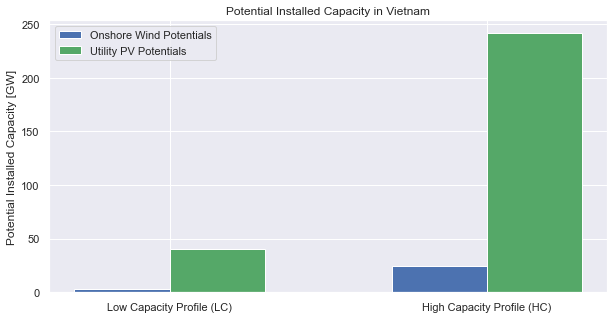

In [13]:
profile_arr = ['Low Capacity Profile (LC)', 'High Capacity Profile (HC)']
y_pos = np.arange(len(profile_arr))

# potential installed capacity
wt_cap_arr = [wt_pc_lc, wt_pc_hc]
pv_cap_arr = [pv_pc_lc, pv_pc_hc]

sns.set(rc={'figure.figsize':(10,5)})
wt_cap_rects = plt.bar(y_pos - 0.15, wt_cap_arr, width= 0.3,  color='b', label='Onshore Wind Potentials')
pv_cap_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.3,  color='g', label='Utility PV Potentials')
plt.xticks(y_pos, profile_arr)
plt.ylabel('Potential Installed Capacity [GW]')
plt.title('Potential Installed Capacity in Vietnam')
plt.savefig('Vietnam/03_output_stage3/03_installed_capacity_comparison.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

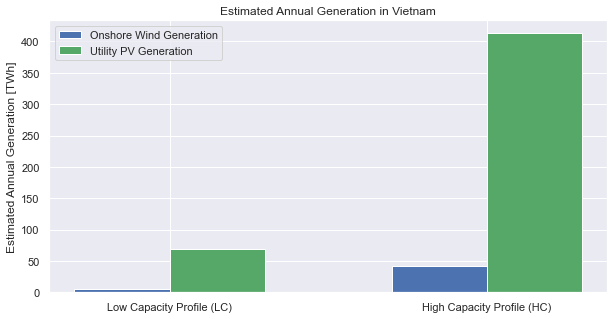

In [14]:
# estimated annual generation
wt_gen_arr = [wt_ag_lc, wt_ag_hc]
pv_gen_arr = [pv_ag_lc, pv_ag_hc]

sns.set(rc={'figure.figsize':(10,5)})
wt_gen_rects = plt.bar(y_pos - 0.15, wt_gen_arr, width= 0.3,  color='b', label='Onshore Wind Generation')
pv_gen_rects = plt.bar(y_pos + 0.15, pv_gen_arr, width=0.3,  color='g', label='Utility PV Generation')
plt.xticks(y_pos, profile_arr)
plt.ylabel('Estimated Annual Generation [TWh]')
plt.title('Estimated Annual Generation in Vietnam')
plt.savefig('Vietnam/03_output_stage3/03_generation_comparison.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

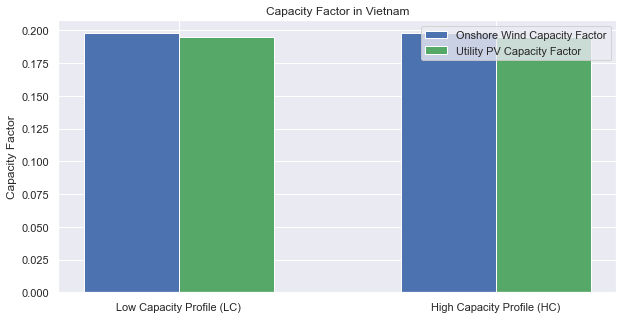

In [15]:
# capacity factor
wt_cf_arr = [wt_cf]
pv_cf_arr = [pv_cf]

sns.set(rc={'figure.figsize':(10,5)})
wt_cf_rects = plt.bar(y_pos - 0.15, wt_cf_arr, width= 0.3,  color='b', label='Onshore Wind Capacity Factor')
pv_cf_rects = plt.bar(y_pos + 0.15, pv_cf_arr, width=0.3,  color='g', label='Utility PV Capacity Factor')
plt.xticks(y_pos, profile_arr)
plt.ylabel('Capacity Factor')
plt.title('Capacity Factor in Vietnam')
plt.savefig('Vietnam/03_output_stage3/03_cf_comparison.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

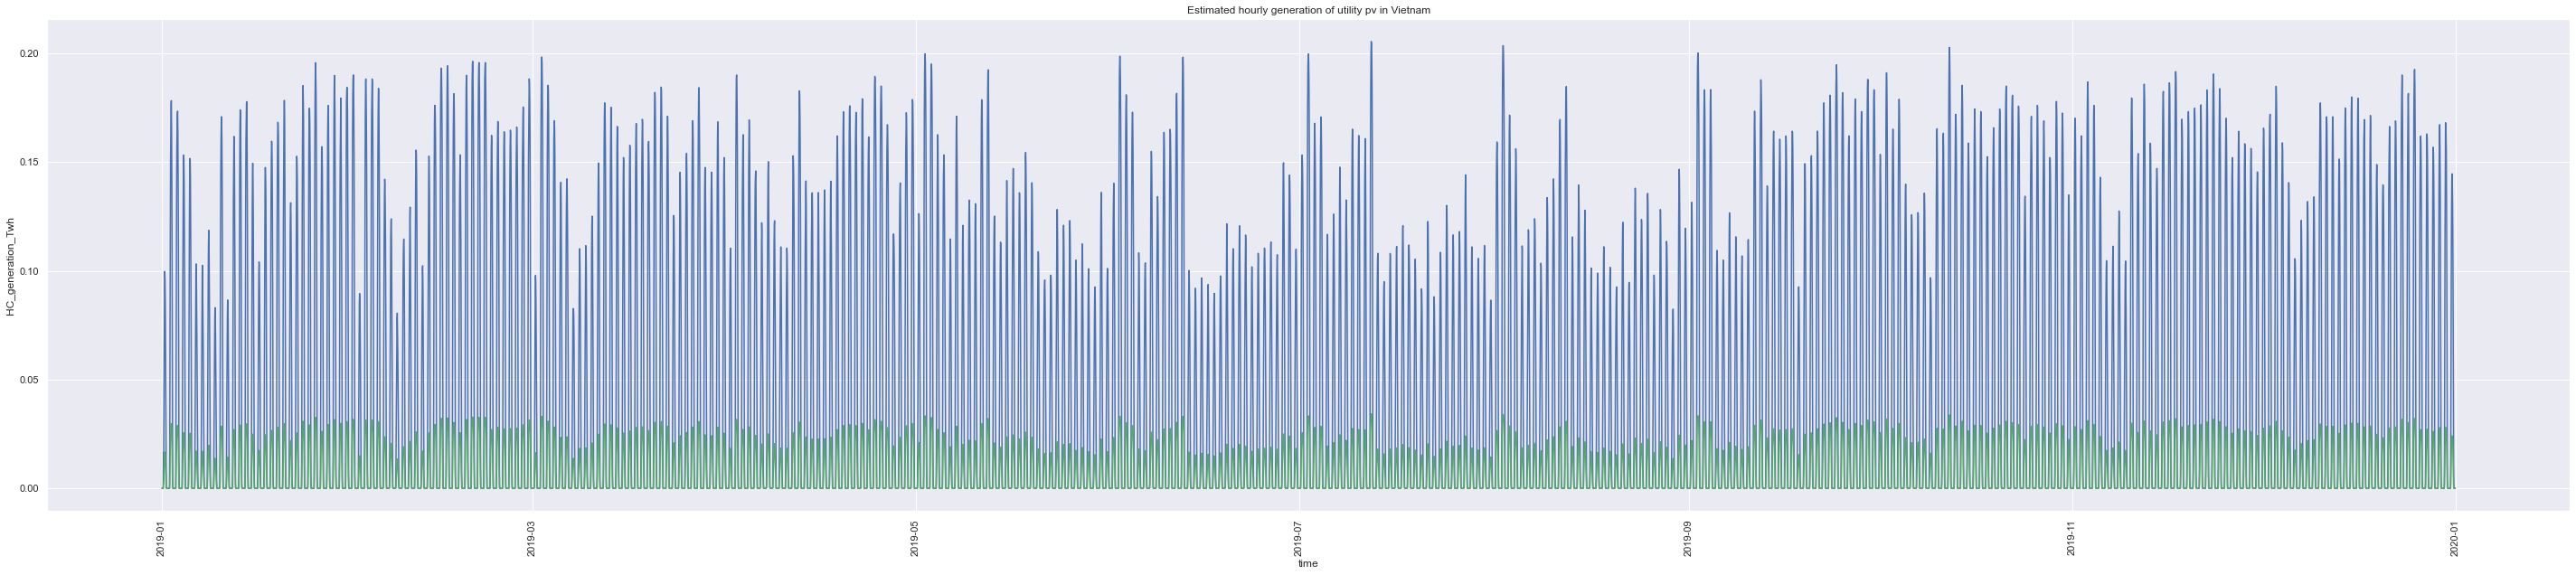

In [17]:
# pv hourly generation
f, ax = plt.subplots(1, 1)
#sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="HC_generation_Twh",  color='b', data=pv_ag_hourly_df)
sns.lineplot(x="time", y="LC_generation_Twh",  color='g', data=pv_ag_hourly_df)
plt.xticks(rotation='vertical')
plt.title('Estimated hourly generation of utility pv in Vietnam')
plt.savefig('Vietnam/03_output_stage3/03_pv_gen_hourly.tiff', dpi=300)
plt.show()

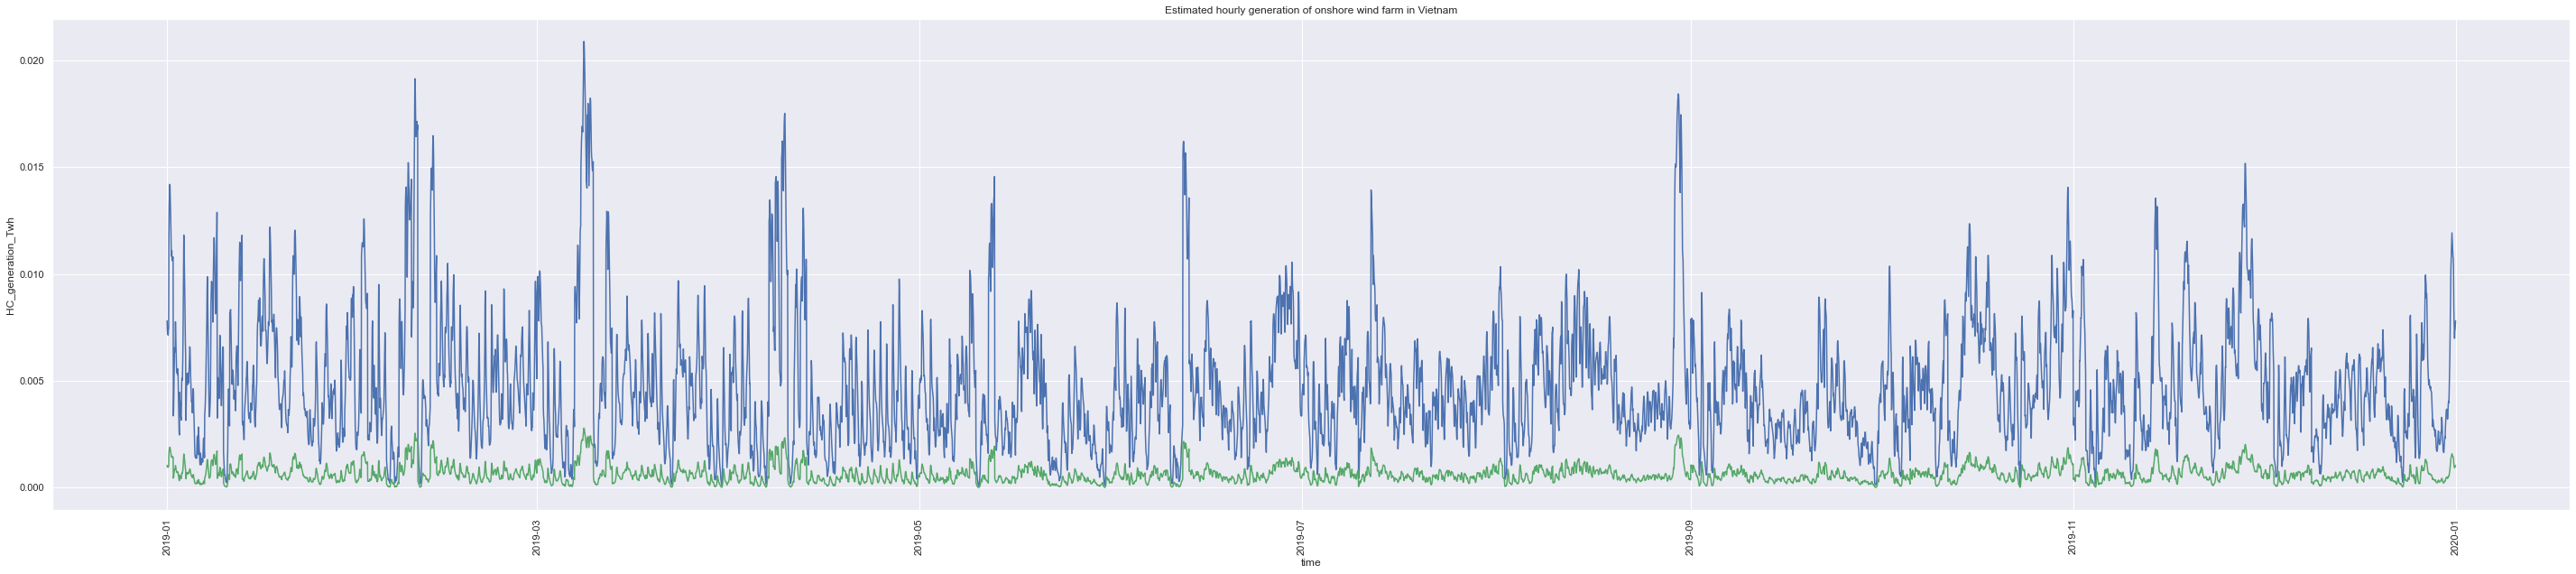

In [18]:
# wt hourly generation
f, ax = plt.subplots(1, 1)
#sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="HC_generation_Twh",  color='b', data=wt_ag_hourly_df)
sns.lineplot(x="time", y="LC_generation_Twh",  color='g', data=wt_ag_hourly_df)
plt.xticks(rotation='vertical')
plt.title('Estimated hourly generation of onshore wind farm in Vietnam')
plt.savefig('Vietnam/03_output_stage3/03_wt_gen_hourly.tiff', dpi=300)
plt.show()